# Procesamiento de Lenguaje Natural - **Selección de características**

Esta notebook presenta ejemplos de los diferentes aspectos relacionados con las técnicas de selección de características vistas en clase. La Selección de Características (feature selection) es una forma de reducción de dimensionalidad que consiste en seleccionar las características más relevantes de un conjunto de datos, con el objetivo de disminuir el costo computacional del aprendizaje y mejorar la performance de los predictores.

In [ ]:
pip install openml

     |████████████████████████████████| 122kB 6.5MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
  Created wheel for openml: filename=openml-0.12.2-cp37-none-any.whl size=137325 sha256=1ccf24bda3fd674318f58b048fd9d4a9c26ef154f254ec05e4da732689f4c123
  Stored in directory: /root/.cache/pip/wheels/9a/14/d2/8abbfdd178687346fe38718696f3696e6a523ff7318086458e
  Created wheel for liac-arff: filename=liac_arff-2.5.0-cp37-none-any.whl size=11732 sha256=fa6a181a2364f28985d7d2e5078dbcba632b95850070300c978bc7177292ef47
  Stored in directory: /root/.cache/pip/wheels/77/8d/b4/8bfce5beea9a3496cc15b24961876adb7b6e2912ff09164179
Successfully built openml liac-arff


In [ ]:
import openml

dataset = openml.datasets.get_dataset(41496)
print(dataset.description)

This dataset contains 358 lyrics of songs for the rock bands 'The Rolling Stones' and 'Deep Purple'. The bands are equally represented in the dataset (179 songs for each band). This dataset was extracted from the much larger 'SongLyrics' dataset created by Sergey Kuznetsov.


In [ ]:
import pandas as pd

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format='dataframe',
    target=dataset.default_target_attribute
)

songs = pd.DataFrame(X, columns=attribute_names)
songs['target_class'] = y

print(songs[:10])

                                                text    target_class
0  Now if you want to hear some boogie like I'm g...  Rolling Stones
1  Did you ever feel the pain  \nThat he felt upo...  Rolling Stones
2  You can walk through fire  \nMake the north wi...     Deep Purple
3  Have you ever had a woman that could make you ...     Deep Purple
4  Little Indian girl, where is your mama?  \nLit...  Rolling Stones
5  Flying through the night in a beat up wagon  \...     Deep Purple
6  Here's father, his heart screwed on  \nYes, he...  Rolling Stones
7  When I come home baby  \nAnd I've been working...  Rolling Stones
8  I had a dream last night  \nThat I was pilotin...  Rolling Stones
9  We all came out to Montreux  \nOn the Lake Gen...     Deep Purple


In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install contractions

     |████████████████████████████████| 327kB 7.1MB/s 
     |████████████████████████████████| 286kB 36.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85396 sha256=20101744d60e0c0b62169ac3ea2b468285c03b790f75ea5bbc34227b467da28a
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import wordpunct_tokenize
from nltk.stem import SnowballStemmer
import re
import contractions

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = nltk.corpus.stopwords.words('english')
        self.stemmer    = SnowballStemmer(u'english')

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):

        return [
            ' '.join(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, sent):
        
        # una oración del documento
        sent = contractions.fix(sent)
        sent = re.sub(r'[^a-zA-Z\s]', '', sent, re.I|re.A)

        new_sent = []
        for token in wordpunct_tokenize(sent):
             # aplicamos pre-procesamiento al token
             token = token.lower() 
             token = token.strip()
             
             token = self.stemmer.stem(token)

             # ignoramos el token si es un stopword
             if token in self.stopwords:
                continue
             new_sent.append(token)
        return new_sent

In [ ]:
processed_corpus = NLTKPreprocessor().transform(songs['text'])
print(processed_corpus)

['want hear boogi like go play old piano knockout bass drummer man cat call charli mccoy know rememb rubber leg boy mama cookin chicken fri bacon greas come along boy road apiec well place realli get kick open everi night twelv six want hear boogi get fill shove sting like old steam drill come along lose lead road road road apiec well place realli get kick open everi night twelv six want hear boogi get fill shove sting like old steam drill come along lose lead road road road apiec', 'ever feel pain felt upon cross ever feel knife tear flesh oh soft ever touch night ever count cost hide away fear put paradis lost yeah blind rainbow watch wind blow blind rainbow dream night sleep night doubt ever feel blast semtex bomb goe ever hear scream limb torn ever kiss child saw father shot ever would tear war drag ever touch night anoth job feel final hour put paradis lost yeah blind rainbow face window blind rainbow dream night sleep night doubt ever fear night could war lost fear final hour kne

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english')

tfidf_matrix = vectorizer.fit_transform(processed_corpus)
songs = tfidf_matrix.toarray()
features = vectorizer.get_feature_names()

df_songs = pd.DataFrame(songs, columns=features)

le = LabelEncoder()
le.fit(np.unique(y))

df_songs['target_class'] = le.transform(y)
df_songs

,aaaaall,aaaah,aaaahh,aaaall,aaah,aaahhhh,aah,aahh,aahoh,aaron,aawaahohh,abebybickyoubygogogoyeah,abid,abl,aboard,abov,absurd,abund,abus,ac,academi,accept,accid,accident,accommod,accur,accus,ace,ach,achill,achin,act,action,actor,ad,add,addict,addit,address,admir,...,wrinkl,wrist,write,writer,written,wrong,wrote,ya,yaketyyak,yaknow,yap,yard,ye,yea,yeah,year,yeayeayeah,yeayeayeayeah,yeayeyeah,yeck,yeh,yell,yellow,yep,yes,yesterday,yield,york,young,younger,yous,yucki,zappa,zeno,zero,zip,zipper,zombi,zone,target_class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071148,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210262,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071087,0.0,0.0,0.0,0.091527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.019824,0.032032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
from numpy import count_nonzero

sparsity = 1.0 - ( count_nonzero(songs) / float(songs.size) )
print(sparsity)

0.9862023674422304


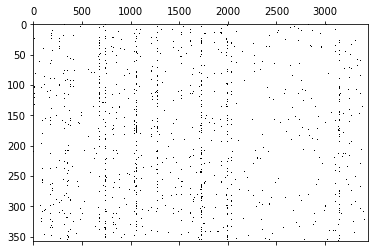

In [ ]:
import matplotlib.pylab as plt
import scipy.sparse as sparse

A = sparse.eye(100)
plt.spy(songs,aspect='auto')

In [ ]:
from sklearn.model_selection import train_test_split

# particionar el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(
    df_songs.drop(labels=['target_class'], axis=1),
    df_songs['target_class'],
    test_size=0.2,
    random_state=0,stratify= df_songs['target_class'])

X_train.shape, X_test.shape

((286, 3441), (72, 3441))

In [ ]:
# Mantener una copia del dataset con todas las variables para comparar al final

X_train_original = X_train.copy()
X_test_original = X_test.copy()

## **Métodos de Selección Univariado**

La selección  univariada examina cada característica individualmente para determinar la fuerza de la relación de la característica con la clase. Estos métodos son simples de ejecutar y comprender y, en general, son particularmente buenos para obtener una reducción datos (pero no necesariamente para optimizar el conjunto de características para una mejor generalización).


### Remover features constantes o quasi-constantes

VarianceThreshold es una forma simple de selección que elimina las características con baja varianza. Por defecto, conserva todas las características de varianza distinta de cero, es decir, elimina características que tienen el mismo valor en todos los ejemplos.

Este filtro observa la varianza de una característica sola, no considera la clase, por lo tanto es no supervisado. 


In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.00005)  

selector.fit(X_train)  

sum(selector.get_support()) 

2039

In [ ]:
features_to_keep = X_train.columns[selector.get_support()]

print(features_to_keep)

# se remueven las restantes variables
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

X_train.shape, X_test.shape

Index(['aaaaall', 'aaaah', 'aaaahh', 'aahh', 'aaron', 'abl', 'abov', 'absurd',
       'abus', 'ac',
       ...
       'yellow', 'yep', 'yes', 'yesterday', 'young', 'younger', 'zappa',
       'zeno', 'zero', 'zone'],
      dtype='object', length=2039)


((286, 2039), (72, 2039))

In [ ]:
# las transformaciones llevan a numpy arrays, por lo que se transforman nuevamente a dataframes

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

# guardar el dataset reducido para usar más adelante
X_train_reduced = X_train.copy()
X_test_reduced = X_test.copy()

In [ ]:
# se define un clasificador SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def run_SVM(X_train, X_test, y_train, y_test):
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(X_train, y_train)
  predicted = clf.predict(X_test)
  print("Accuracy : "+str(accuracy_score(y_test, predicted)))
  print("F1 score : "+str(f1_score(y_test, predicted)))

In [ ]:
print("Clasificación con el dataset original:")
run_SVM(X_train_original, X_test_original, y_train, y_test)
print("------------------------")
print("Clasificación después de la eliminación de características:")
run_SVM(X_train, X_test, y_train, y_test)


Clasificación con el dataset original:
Accuracy : 0.4583333333333333
F1 score : 0.4657534246575342
------------------------
Clasificación después de la eliminación de características:
Accuracy : 0.4861111111111111
F1 score : 0.5432098765432098


### Remover features correlacionadas

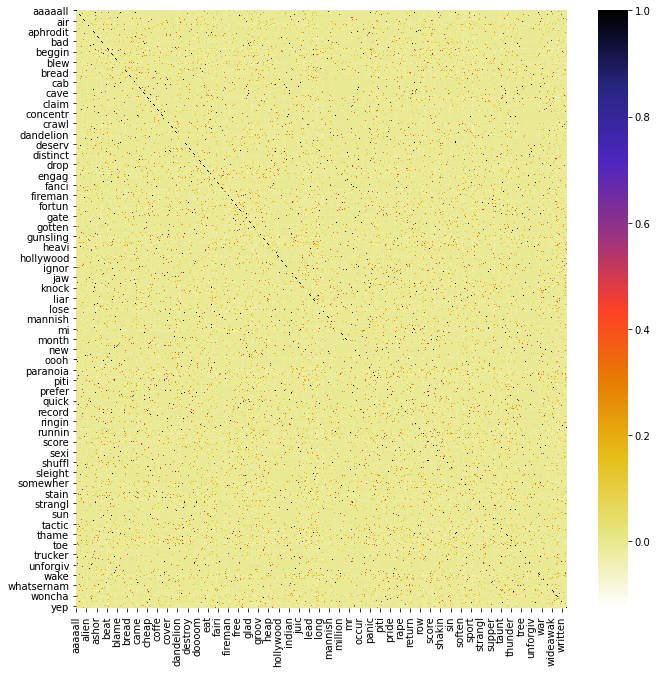

In [ ]:
import seaborn as sns

#Using Pearson Correlation
corrmat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat, cmap=plt.cm.CMRmap_r)

In [ ]:
# la función selecciona características altamente correlacionadas
# para eliminar la primera característica que esté correlaciona con otra
data_corr = []

def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # valor absoluto del coeficiente de correlación
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                data_corr.append([corr_matrix.columns[i],corr_matrix.columns[j],corr_matrix.iloc[i, j]])
    return col_corr, data_corr

In [ ]:
corr_features, data_corr = correlation(X_train, 0.9)
len(set(corr_features))

678

In [ ]:
corrdata=pd.DataFrame(data_corr)
corrdata.columns=['Feature 1','Feature 2','corr_value']
corrdata

,Feature 1,Feature 2,corr_value
0,aahh,aaaahh,1.0
1,admir,aaaah,1.0
2,alien,academi,1.0
3,appl,allow,1.0
4,artist,ac,1.0
...,...,...,...
2865,zeno,rein,1.0
2866,zeno,toytus,1.0
2867,zero,meltdown,1.0
2868,zero,prefer,1.0


In [ ]:
X_train = X_train.drop(corr_features,axis=1)
X_test = X_test.drop(corr_features,axis=1)

In [ ]:
print(X_train.shape)
print("Clasificación después de la eliminación por correlación:")
run_SVM(X_train, X_test, y_train, y_test)

(286, 1361)
Clasificación después de la eliminación por correlación:
Accuracy : 0.5277777777777778
F1 score : 0.5405405405405405


## Ranking basado en métricas de información

Mutual information (MI) entre dos variables es un valor no negativo que mide la dependencia entre ambas. Es cero sí y solo sí las variables son independientes, valores más altos indican mayor dependendencia.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# calcular la información mutua entre cada feature y la clase
mutual_info = mutual_info_classif(X_train.fillna(0), y_train, random_state=0)

mi_series = pd.Series(mutual_info)
mi_series.index = X_train.columns
mi_series.sort_values(ascending=False)

stand      0.120150
know       0.118899
true       0.113145
lesson     0.101711
thing      0.096503
             ...   
let        0.000000
lend       0.000000
led        0.000000
leav       0.000000
aaaaall    0.000000
Length: 1361, dtype: float64

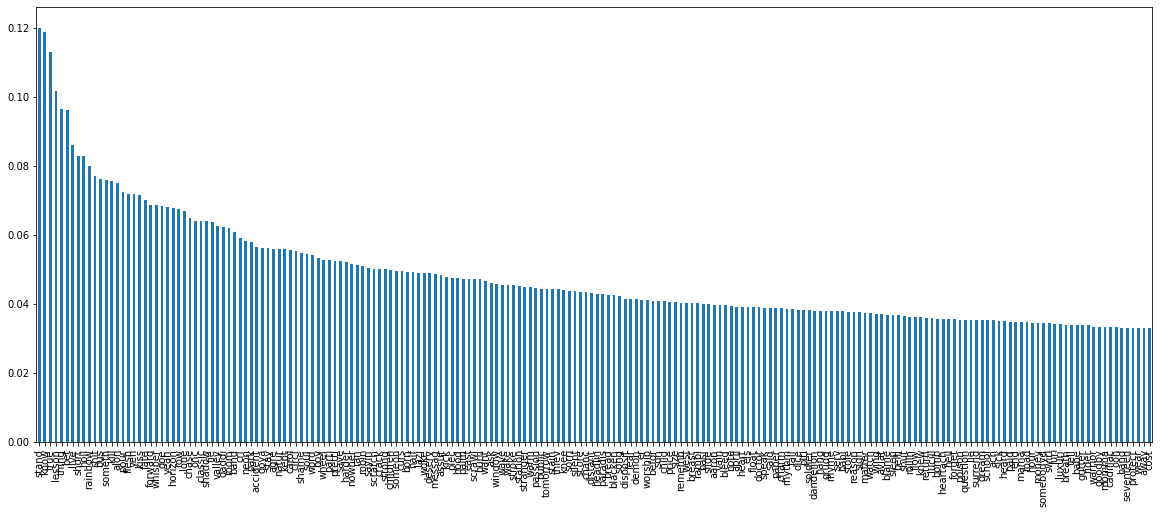

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mi_series.sort_values(ascending=False).head(200).plot.bar(figsize=(20,8))

El gráfico muestra las características ordenadas en base a MI. 

El proceso de selección consiste en determinar qué características conservar para el aprendizaje. Se pueden seleccionar las k mejores con **SelectKbest** o un porcentaje con **SelectPercentile**.

In [ ]:
#rearmar el dataset para cross-validation
X = np.r_[X_train, X_test]
y = np.r_[y_train, y_test]

100%|██████████| 11/11 [04:30<00:00, 24.62s/it]


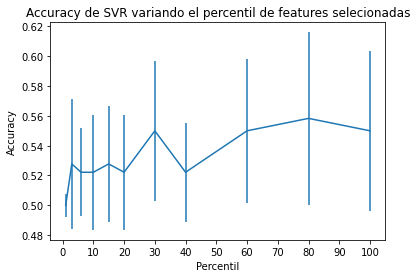

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from tqdm import tqdm # para poder ver el progreso

clf = Pipeline([('fs', SelectPercentile(mutual_info_classif)),
                ('svc', SVC(gamma="auto"))])

# Plotear el score de cross-validation como función del percentil de features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)
np.random.seed(0)

for percentile in tqdm(percentiles):
    clf.set_params(fs__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('Accuracy de SVR variando el percentil de features selecionadas')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentil')
plt.ylabel('Accuracy')
plt.axis('tight')
plt.show()

100%|██████████| 11/11 [05:23<00:00, 29.39s/it]


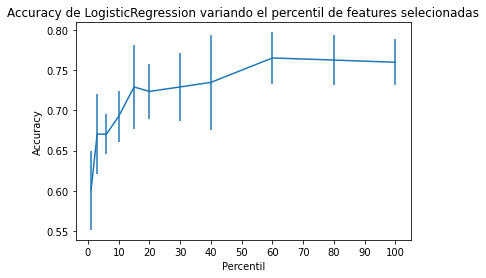

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

clf = Pipeline([('fs', SelectPercentile(mutual_info_classif)),
                ('svc', LogisticRegression(solver='sag'))])

# Plotear el score de cross-validation como función del percentil de features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)
np.random.seed(0)

for percentile in tqdm(percentiles):
    clf.set_params(fs__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('Accuracy de LogisticRegression variando el percentil de features selecionadas')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentil')
plt.ylabel('Accuracy')
plt.axis('tight')
plt.show()

## Forward Feature Selection

Forward Feature Selection comienza evaluando todas las características individualmente y selecciona la que genera el mejor rendimiento, de acuerdo con un criterio de evaluación preestablecido. En el segundo paso, evalúa todas las combinaciones posibles de la característica seleccionada y una segunda característica, y selecciona el par que produce el mejor rendimiento basado en los mismos criterios.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(SVC(kernel="linear"),
          k_features=10,
          forward=True,
          floating=False,
          verbose=2,
          scoring='accuracy',
          cv=3)

sfs = sfs.fit(np.array(X_train.fillna(0)), y_train)

selected_features= X_train.columns[list(sfs.k_feature_idx_)]
selected_features

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1361 out of 1361 | elapsed:    9.9s finished

[2021-07-02 20:21:13] Features: 1/10 -- score: 0.5593932748538012[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1360 out of 1360 | elapsed:   10.2s finished

[2021-07-02 20:21:24] Fea

Index(['affair', 'babi', 'blood', 'daddi', 'got', 'know', 'pleas', 'space',
       'woman', 'yeah'],
      dtype='object')

## Selección Embebida

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()      
clr = clf.fit(X_train,y_train)
importances = clr.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]


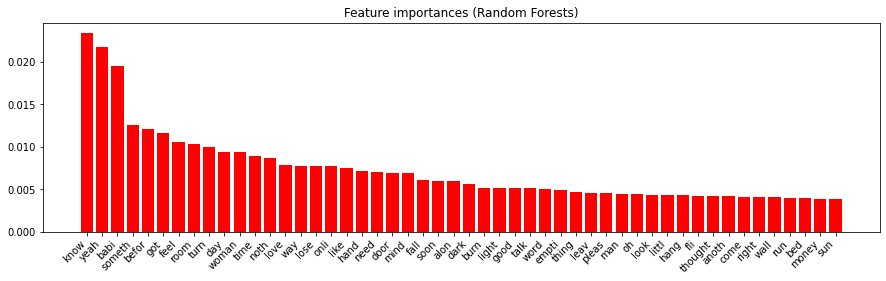

In [ ]:
plt.figure(figsize=(15,5))

plt.title("Feature importances (Random Forests)")
plt.bar(range(50), importances[indices[:50]],
       color="r", align="center")
plt.xticks(range(50), X_train.columns[indices[:50]], rotation=45, ha='right')

plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

## Recursive Feature Elimination

Dado un estimador externo que asigna peso a las características, el objetivo de RFE es seleccionar features considerando recursivamente conjuntos cada vez más chicos. Primero, el estimador se entrena con el conjunto inicial de características y se obtiene la importancia de las características. Entonces las menos importantes se van descartando del conjunto. El procedimiento se repite hasta que se alcanza el número deseado de características.

RFECV - Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

Número óptimo de features : 118


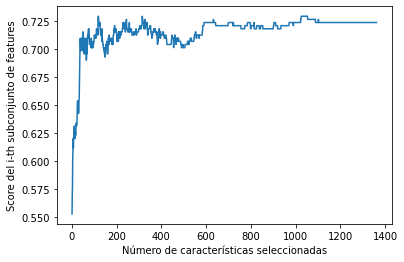

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

svc = SVC(kernel="linear")

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, y)

print("Número óptimo de features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Número de características seleccionadas")
plt.ylabel("Score del i-th subconjunto de features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()